In [1]:
import sys; sys.path.insert(0, '..')
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.text import Text
import seaborn as sns
from ldf.utils import load_ecb_forecasts, get_target_buckets, which_bucket, get_bounds, assign_buckets, create_hist_pivot, count_max_cont_missingness
from ldf.best_subset import best_n_avg
%load_ext autoreload
%autoreload 2

sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":20,"axes.labelsize":20})
plt.rc('legend',fontsize=16)
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Load data

In [2]:
data_folder = r"..//data//ECB"

In [3]:
history = load_ecb_forecasts(data_folder, start="1991Q1", end="2019Q3")

In [4]:
print("There are", history.TARGET_PERIOD.nunique(), "quarterly surveys, starting", history.FORECAST_DATE.min(), "and ending", history.FORECAST_DATE.max())
print("There are", history.FCT_SOURCE.nunique(), "unique forecasters")

There are 83 quarterly surveys, starting 1999Q1 and ending 2019Q3
There are 108 unique forecasters


In [5]:
history.head()

,TARGET_PERIOD,FCT_SOURCE,POINT,PERIOD_ENUM,FORECAST_DATE,T0_0,F0_0T0_4,F0_5T0_9,F1_0T1_4,F1_5T1_9,...,F3_0T3_4,F3_5,F3_5T3_9,F4_0,TN2_0,FN2_0TN1_6,FN1_5TN1_1,FN1_0TN0_6,FN0_5TN0_1,TN1_0
0,1999Dec,1,1.2,0,1999Q1,NaN,NaN,10,80,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999Dec,2,1.2,0,1999Q1,NaN,10,30,50,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1999Dec,3,.8,0,1999Q1,NaN,30,40,20,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1999Dec,4,1.3,0,1999Q1,NaN,NaN,NaN,60,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1999Dec,5,1.1,0,1999Q1,NaN,5,20,75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Define buckets

In [6]:
buckets_from = [None, -0.5, 0.0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
buckets_to = [-0.5, 0.0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4.0, None]
target_buckets = get_target_buckets(buckets_from, buckets_to)

In [7]:
buckets_in_history = history.columns[5:].to_list()
assigned_buckets = assign_buckets(target_buckets, buckets_in_history)
assigned_buckets

{'TN0_5': ['TN2_0', 'FN2_0TN1_6', 'FN1_5TN1_1', 'FN1_0TN0_6', 'TN1_0'],
 'FN0_5T0_0': ['T0_0', 'FN0_5TN0_1'],
 'F0_0T0_5': ['F0_0T0_4'],
 'F0_5T1_0': ['F0_5T0_9'],
 'F1_0T1_5': ['F1_0T1_4'],
 'F1_5T2_0': ['F1_5T1_9'],
 'F2_0T2_5': ['F2_0T2_4'],
 'F2_5T3_0': ['F2_5T2_9'],
 'F3_0T3_5': ['F3_0T3_4'],
 'F3_5T4_0': ['F3_5', 'F3_5T3_9'],
 'F4_0': ['F4_0']}

### Create clean history

In [8]:
history_clean = pd.DataFrame()
history_clean["PERIOD_ENUM"] = history["PERIOD_ENUM"].copy()
history_clean["FORECAST_DATE"] = history["FORECAST_DATE"].copy()
history_clean["TARGET_PERIOD"] = history["TARGET_PERIOD"].copy()
history_clean["FCT_SOURCE"] = history["FCT_SOURCE"].copy()
history_clean["POINT"] = history["POINT"].copy()
for tb in target_buckets:
    history_clean[tb] = np.sum([history[i].fillna(0).astype(float).copy() for i in assigned_buckets[tb]], axis=0)

history_clean["SUM_CHECK"] = history_clean[target_buckets].sum(axis=1)

In [9]:
len(history_clean)

4752

#### Keep only records where point forecast is available or the sum of probabilities is greater than 99

In [10]:
history_clean.FCT_SOURCE.nunique()

108

In [11]:
#history_clean = history_clean[(history_clean.SUM_CHECK > 80)] 
history_clean = history_clean[~pd.isna(history_clean.POINT) | (history_clean.SUM_CHECK > 80)] 
history_clean.FCT_SOURCE.nunique()

106

##### Assign 100% probability to the bucket corresponding to point forecast if probabilities are set to 0

In [12]:
float(history_clean.iloc[6].POINT)

0.8

In [13]:
history_clean.loc[(history_clean.SUM_CHECK < 80)]

,PERIOD_ENUM,FORECAST_DATE,TARGET_PERIOD,FCT_SOURCE,POINT,TN0_5,FN0_5T0_0,F0_0T0_5,F0_5T1_0,F1_0T1_5,F1_5T2_0,F2_0T2_5,F2_5T3_0,F3_0T3_5,F3_5T4_0,F4_0,SUM_CHECK
6,0,1999Q1,1999Dec,7,.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0,1999Q1,1999Dec,31,1.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0,1999Q1,1999Dec,35,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,0,1999Q1,1999Dec,63,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54,0,1999Q1,1999Dec,76,1.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4736,82,2019Q3,2020Jun,97,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4738,82,2019Q3,2020Jun,99,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4739,82,2019Q3,2020Jun,101,1.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4740,82,2019Q3,2020Jun,102,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
for i in history_clean[(history_clean.SUM_CHECK < 80)].index:
    history_clean.loc[(history_clean.index == i) , which_bucket(float(history_clean[(history_clean.index == i)].POINT))] = 100
    
history_clean.loc[(history_clean.SUM_CHECK < 80), "SUM_CHECK"] = 100

In [15]:
print(history_clean.SUM_CHECK.max(), history_clean.SUM_CHECK.min())

100.82403923427678 99.4562199410901


In [16]:
history_clean.tail()

,PERIOD_ENUM,FORECAST_DATE,TARGET_PERIOD,FCT_SOURCE,POINT,TN0_5,FN0_5T0_0,F0_0T0_5,F0_5T1_0,F1_0T1_5,F1_5T2_0,F2_0T2_5,F2_5T3_0,F3_0T3_5,F3_5T4_0,F4_0,SUM_CHECK
4747,82,2019Q3,2020Jun,114,1.9,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.0
4748,82,2019Q3,2020Jun,115,1.4,1.463042,3.639768,8.683348,15.501909,20.711933,20.711933,15.501909,8.683348,3.639768,1.141479,0.321563,100.0
4749,82,2019Q3,2020Jun,116,1.1,0.000000,0.000000,5.000000,25.000000,35.000000,25.000000,10.000000,0.000000,0.000000,0.000000,0.000000,100.0
4750,82,2019Q3,2020Jun,127,1.5,0.229417,1.330299,5.640933,14.998618,25.027360,26.220716,17.248786,7.121811,1.844189,0.299181,0.038691,100.0
4751,82,2019Q3,2020Jun,128,1.5,0.000000,1.000000,2.000000,4.000000,30.000000,50.000000,10.000000,2.000000,1.000000,0.000000,0.000000,100.0


#### Check for the misdefined forecasts

In [17]:
history_clean[(history_clean.SUM_CHECK > 10) & (history_clean.SUM_CHECK < 99.5)]

,PERIOD_ENUM,FORECAST_DATE,TARGET_PERIOD,FCT_SOURCE,POINT,TN0_5,FN0_5T0_0,F0_0T0_5,F0_5T1_0,F1_0T1_5,F1_5T2_0,F2_0T2_5,F2_5T3_0,F3_0T3_5,F3_5T4_0,F4_0,SUM_CHECK
941,16,2003Q1,2003Dec,10,1.65713259,0.0,0.813174,3.328222,10.951328,20.949315,26.110582,21.206864,11.222347,3.867643,1.006746,0.0,99.45622


### Find which forecasters were contributing frequently

In [18]:
hist = create_hist_pivot(history_clean)

In [19]:
hist.head()

FCT_SOURCE,1,2,3,4,5,6,7,8,9,10,...,111,112,113,114,115,116,118,119,127,128
DATE,,,,,,,,,,,,,,,,,,,,,
1999-12-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-03-01,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-01,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-01,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-01,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Count maximum contiguous missingness

In [20]:
d_max_nan = count_max_cont_missingness(hist)
d_max_nan.head()

,Count
1,2
2,3
3,17
4,1
5,3


#### Check how many forecasters contributed with less than a year break between consecutive forecasts

In [21]:
missing_mask = d_max_nan["Count"] < 5
len(d_max_nan[missing_mask].index)

17

In [22]:
hist[d_max_nan[missing_mask].index.tolist() + ["96"]]

FCT_SOURCE,1,2,4,5,16,20,24,26,37,39,47,48,52,54,89,94,95,96
DATE,,,,,,,,,,,,,,,,,,
1999-12-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN
2000-03-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN
2000-06-01,1.0,NaN,NaN,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN
2000-09-01,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,NaN
2000-12-01,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-01,NaN,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2019-09-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0
2019-12-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0


In [23]:
relevant_forecasters = d_max_nan[missing_mask].index.to_list() #+ ["96"]

In [24]:
len(relevant_forecasters)

17

#### Total number of forecasters

In [25]:
len(history_clean.FCT_SOURCE.astype(int).sort_values().astype("str").unique())

106

In [26]:
history_clean = history_clean[history_clean.FCT_SOURCE.isin(relevant_forecasters)]

### Histograms

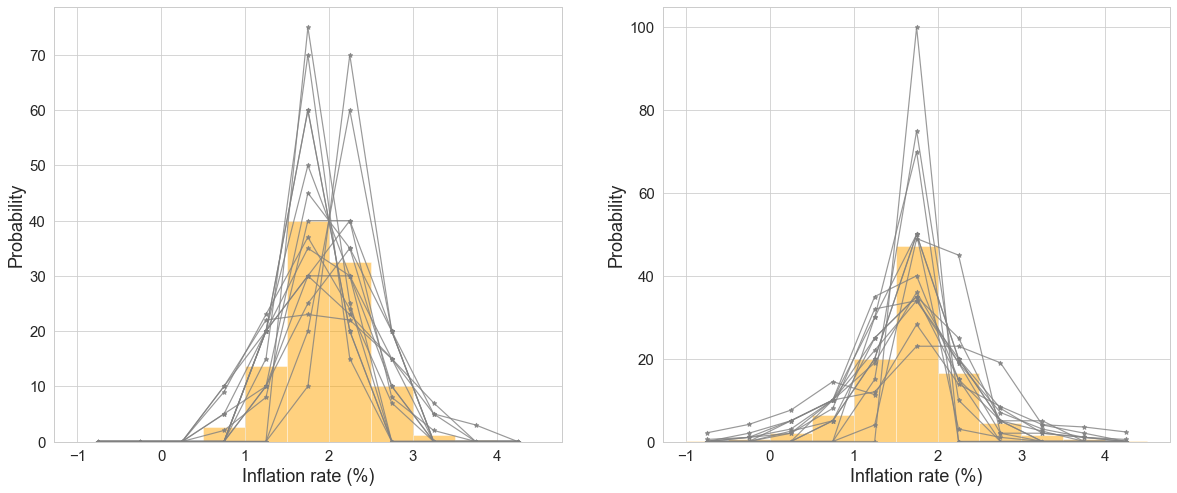

In [27]:
forecasts = ["2004Q4" , "2018Q4"]
fig, axs = plt.subplots(1, len(forecasts) , figsize=(20,8), sharey=False)
x_axis = (np.array([-1] + buckets_from[1:]) + np.array(buckets_to[:-1]+[4.5])) * 0.5
for j in range(len(forecasts)):
    axs[j].bar(x_axis, history_clean[history_clean.FORECAST_DATE==forecasts[j]][target_buckets].mean().values, color="orange", alpha=0.5, width=0.5)
    for i in range(len(history_clean[history_clean.FORECAST_DATE==forecasts[j]])):
        axs[j].plot(x_axis, history_clean[history_clean.FORECAST_DATE==forecasts[j]][target_buckets].iloc[i].values, c="grey", marker="*", alpha=0.8)
    axs[j].set_ylabel("Probability")
    axs[j].set_xlabel("Inflation rate (%)")
    axs[j].tick_params(axis='both', which='both', labelsize=15)

### Translate point forecasts to bucket predictions

In [28]:
def fill_prob(x):
    bucket = which_bucket(float(x.POINT))
    x[bucket] = 100
    x["SUM_CHECK"] = 100
    return x

In [29]:
mask = history_clean.SUM_CHECK < 99
to_be_filled = history_clean[mask].copy()
history_clean.loc[mask, :] = to_be_filled.apply(lambda x: fill_prob(x), axis=1)

## Load inflation history (realised)

In [30]:
hicp = pd.read_csv(data_folder + f"\\HICP.csv", header=0)
hicp["DATE"] = pd.to_datetime(hicp["DATE"], format="%d/%m/%Y")
hicp = hicp[hicp.columns[:-1]]
hicp.columns = ["DATE", "LEVEL", "CHANGE"]
hicp["CHANGE"] = 100 * hicp["CHANGE"]

In [31]:
hicp.head()

,DATE,LEVEL,CHANGE
0,1996-01-01,70.40,NaN
1,1996-02-01,70.71,NaN
2,1996-03-01,71.01,NaN
3,1996-04-01,71.14,NaN
4,1996-05-01,71.32,NaN


### Enrich clean history with the dates and merge with realised inflation

In [32]:
history_clean = history_clean[history_clean.FCT_SOURCE.isin(relevant_forecasters)]
history_clean["YEAR"] = history_clean["TARGET_PERIOD"].str[:4]
history_clean["MONTH"] = history_clean["TARGET_PERIOD"].str[4:]
history_clean.loc[history_clean["MONTH"]=="Mar", "MONTH"] = 3
history_clean.loc[history_clean["MONTH"]=="Jun", "MONTH"] = 6
history_clean.loc[history_clean["MONTH"]=="Sep", "MONTH"] = 9
history_clean.loc[history_clean["MONTH"]=="Dec", "MONTH"] = 12
history_clean["DATE"] = pd.to_datetime(history_clean[['YEAR', 'MONTH']].assign(DAY=1))

In [33]:
history_clean = history_clean.merge(hicp, on="DATE", how="left")

In [34]:
history_clean["BUCKET"] = history_clean.apply(lambda x: which_bucket(x['CHANGE']),axis=1)

#### Calculate log-likelihoods

In [35]:
log_lik = []
lik = []
for i in range(len(history_clean)):
    x = history_clean[history_clean["BUCKET"].iloc[i]].copy()[i] / 100
    if x == 0:
        x = 0.01
        non_zero_col = history_clean[target_buckets].iloc[i][history_clean[target_buckets].iloc[i] > 0]
        history_clean.loc[i, non_zero_col.index] = history_clean[non_zero_col.index].iloc[i]- 1 / len(non_zero_col)
        history_clean.loc[i, history_clean["BUCKET"].iloc[i]] = 1
    lik.append(x)
    log_lik.append(np.log(x))
    
history_clean["LOG_LIK"] = log_lik
history_clean["LIK"] = lik

In [36]:
all_forecasters = history_clean.FCT_SOURCE.unique()
all_periods = history_clean.TARGET_PERIOD.unique()

## Filling missing values

In [37]:
filled_history = pd.DataFrame()

#### First period

In [38]:
# missing forecasters in the first period
first_period_forecasters = history_clean[history_clean.TARGET_PERIOD == all_periods[0]].FCT_SOURCE.unique()
first_period_missing_forecasters = [i for i in all_forecasters if i not in first_period_forecasters]
filled_history = pd.concat([filled_history, 
                          history_clean[(history_clean.FCT_SOURCE.isin(first_period_forecasters)) & (history_clean.TARGET_PERIOD == all_periods[0])].copy()])

In [39]:
av = history_clean[history_clean.TARGET_PERIOD == all_periods[0]][target_buckets].mean().to_dict()
for j, f in enumerate(first_period_missing_forecasters):
    d = {}
    for c in [i for i in history_clean.columns if (i not in target_buckets) and (i not in ["LOG_LIK"])]:
        d[c] = history_clean[history_clean.TARGET_PERIOD == all_periods[0]][c].iloc[0]
        
    d.update(av)
    d["FCT_SOURCE"] = f
    d = pd.DataFrame(d, index=[j])
    x = d[d["BUCKET"]].values[0][0] / 100
    if x == 0:
        x = 0.01
        non_zero_col = d[target_buckets].iloc[0][d[target_buckets].iloc[0] > 0]
        d.loc[0, non_zero_col.index] = d[non_zero_col.index].iloc[0]- 1 / len(non_zero_col)
        d.loc[0, d["BUCKET"].iloc[0]] = 1
  
    d["LOG_LIK"] = np.log(x)
    d["LIK"] = x
    filled_history = pd.concat([filled_history, d]).reset_index(drop=True)

min_score = filled_history[filled_history.TARGET_PERIOD == all_periods[0]]["LOG_LIK"].min()
max_score = filled_history[filled_history.TARGET_PERIOD == all_periods[0]]["LOG_LIK"].max()
filled_history.loc[filled_history.TARGET_PERIOD == all_periods[0], "GROUP"] = np.array(pd.cut(filled_history[filled_history.TARGET_PERIOD == all_periods[0]]["LOG_LIK"].to_numpy(),np.linspace(min_score*1.01, max_score*0.99, 6), labels=[1, 2, 3, 4, 5], retbins=False))

#### The other periods 

In [40]:
for i, period in enumerate(all_periods[1:]):
    period_forecasters = history_clean[history_clean.TARGET_PERIOD==period].FCT_SOURCE.unique()
    filled_history = pd.concat([filled_history, 
                              history_clean[(history_clean.FCT_SOURCE.isin(period_forecasters)) & (history_clean.TARGET_PERIOD == period)].copy()])
    period_missing_forecasters = [i for i in all_forecasters if i not in period_forecasters]
    #print(i, period, period_missing_forecasters)
    for f in period_missing_forecasters:
        d = {}
        for c in [i for i in history_clean.columns if (i not in target_buckets) and (i not in ["LOG_LIK"])]:
            d[c] = history_clean[history_clean.TARGET_PERIOD == period][c].iloc[0]
        gr = filled_history[(filled_history.TARGET_PERIOD == all_periods[i]) & (filled_history.FCT_SOURCE == f)]["GROUP"].values[0]
        #print(f)
        #print(gr)
        forecasters_in_group = filled_history[(filled_history.GROUP == gr) & (filled_history.TARGET_PERIOD == all_periods[i])].FCT_SOURCE
        #print(forecasters_in_group)
        dd = filled_history[(filled_history.TARGET_PERIOD == all_periods[i]) & (filled_history.FCT_SOURCE.isin(forecasters_in_group))][target_buckets].mean().to_dict()
        #print(dd)
        d.update(dd)
        d["FCT_SOURCE"] = f
        d = pd.DataFrame(d, index=[0])
        x = d[d["BUCKET"]].values[0][0] / 100
        if x == 0:
            x = 0.01
            non_zero_col = d[target_buckets].iloc[0][d[target_buckets].iloc[0] > 0]
            d.loc[0, non_zero_col.index] = d[non_zero_col.index].iloc[0]- 1 / len(non_zero_col)
            d.loc[0, d["BUCKET"].iloc[0]] = 1
                               
        d["LOG_LIK"] = np.log(x)
        d["LIK"] = x
        filled_history = pd.concat([filled_history, d]).reset_index(drop=True)
    
    min_score = filled_history[filled_history.TARGET_PERIOD == period]["LOG_LIK"].min()
    max_score = filled_history[filled_history.TARGET_PERIOD == period]["LOG_LIK"].max()
    #print(min_score, max_score)
    if min_score != max_score:
        groups = np.array(pd.cut(filled_history[filled_history.TARGET_PERIOD==period]["LOG_LIK"].to_numpy(), np.linspace(min_score*1.01, max_score*0.99, 6), labels=[1, 2, 3, 4, 5], retbins=False))
        #print(groups)
        #print(filled_history[filled_history.TARGET_PERIOD==period]["LOG_LIK"], groups)
        filled_history.loc[filled_history.TARGET_PERIOD==period, "GROUP"] = groups
    else:
        filled_history.loc[filled_history.TARGET_PERIOD==period, "GROUP"] = 1

In [41]:
d = {}
ex = pd.DataFrame()
for period in all_periods:
    extr = filled_history[filled_history.TARGET_PERIOD == period].iloc[0].copy()
    extr["FCT_SOURCE"] = "uniform"
    extr[target_buckets] = [100/len(target_buckets)] * len(target_buckets)
    extr["LOG_LIK"] = np.log(extr[target_buckets[0]]/100)
    extr["LIK"] = extr[target_buckets[0]]/100
    extr = pd.DataFrame(extr).T
    ex = pd.concat([ex, extr])
    filled_history = pd.concat([filled_history, extr])
    dd = filled_history[(filled_history.TARGET_PERIOD == period) & (~filled_history.FCT_SOURCE.isin(["uniform"]))][target_buckets].mean().to_dict()
    dd["BUCKET"] = filled_history[filled_history.TARGET_PERIOD == period].BUCKET.iloc[0]
    dd["LOG_LIK"] = np.log(dd[dd["BUCKET"]]/100)
    d[period] = dd

In [42]:
filled_history = filled_history.reset_index(drop=True)
for tb in target_buckets:
    filled_history[tb] = pd.to_numeric(filled_history[tb])

### Individual forecasters's scores

In [43]:
periods = list(d.keys())[8:]
mean_scores = filled_history[(filled_history.TARGET_PERIOD.isin(periods)) & (~filled_history.FCT_SOURCE.isin(["uniform"]))].groupby("FCT_SOURCE").LOG_LIK.apply(np.mean)

In [44]:
sum_scores = filled_history[(filled_history.TARGET_PERIOD.isin(periods)) & (~filled_history.FCT_SOURCE.isin(["uniform"]))].groupby("FCT_SOURCE").LOG_LIK.apply(np.sum)

In [45]:
mean_scores.max()

-2.080576073136034

In [46]:
sum_scores.max()

-156.04320548520255

In [47]:
mean_scores.median()

-2.241097909338052

In [48]:
sum_scores.median()

-168.08234320035388

### Simple average probability rectangles

In [49]:
realisations = filled_history[["TARGET_PERIOD", "CHANGE"]].set_index("TARGET_PERIOD", drop=True).copy().drop_duplicates()
realised_df = pd.DataFrame(index=realisations.index, columns=(np.array([-1] + buckets_from[1:]) + np.array(buckets_to[:-1]+[4.5])) * 0.5)
for i in range(len(realised_df)):
    realised_df.loc[realised_df.index[i], realisations.iloc[i]] = 1.0
realised_df.fillna(0.0, inplace=True)    

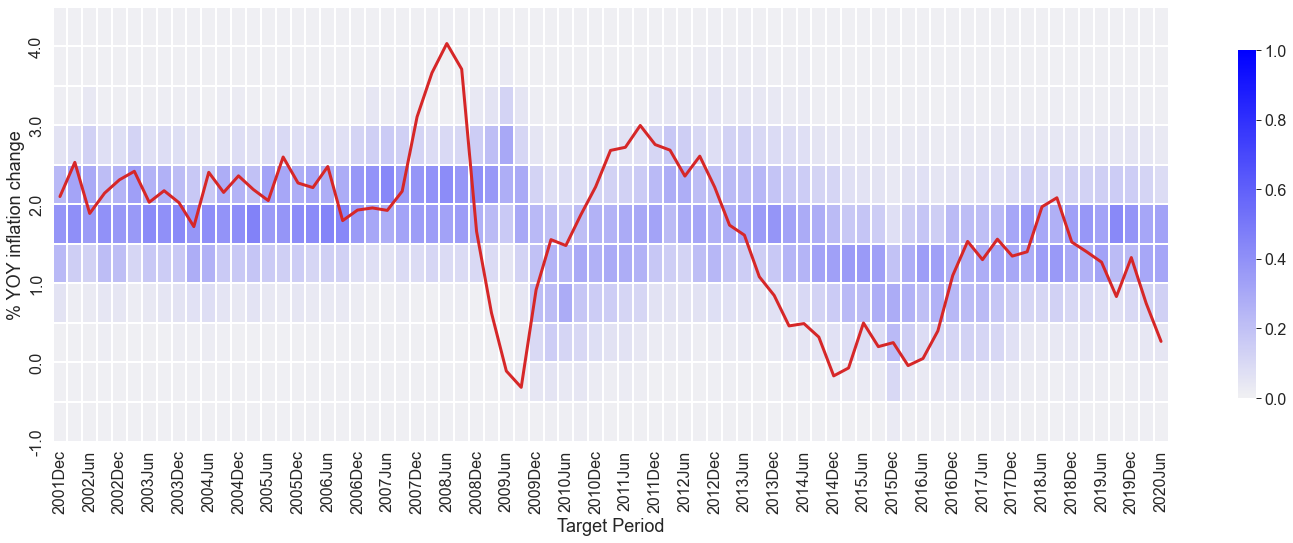

In [50]:
from matplotlib.text import Text
fig, ax = plt.subplots(figsize=(25,8))
filled_history["LIK"]  = filled_history["LIK"].astype("float")
filled_history["CHANGE"]  = filled_history["CHANGE"].astype("float")
cmap = sns.color_palette("light:b", as_cmap=True)
df_avg_prob = filled_history.groupby("TARGET_PERIOD").mean()[target_buckets]
df_avg_prob = df_avg_prob.reindex(realised_df.index)
df_avg_prob.columns = (np.array([-1] + buckets_from[1:]) + np.array(buckets_to[:-1]+[4.5])) * 0.5
sns.heatmap(df_avg_prob[8:].T.iloc[::-1]/100, ax=ax, cmap=cmap,
           linewidth=0.3, cbar_kws={"shrink": .8}, square=False, vmin=0, vmax=1)

ax.set_yticks(np.arange(0,12))
ax.plot(np.arange(0,75)+0.5, -(realisations.CHANGE.values[8:] - 4.5) * (12/6), c="tab:red", lw=3)
ax.set_ylabel("% YOY inflation change")
ax.set_xlabel("Target Period")

ax.set_yticklabels([Text(0, 0.5, ''),
 Text(0, 1, '4.0'),
 Text(0, 2.5, ''),
 Text(0, 3, '3.0'),
 Text(0, 4.5, ''),
 Text(0, 5, '2.0'),
 Text(0, 6.5, ''),
 Text(0, 7, '1.0'),
 Text(0, 8.5, ''),
 Text(0, 9, '0.0'),
 Text(0, 10.5, ''),
 Text(0, 11, '-1.0')])

plt.show()

### Diebold (2021) - best-N forecasters results

In [51]:
n_forecasters = 3
best_4_avg, combinations = best_n_avg(relevant_forecasters + ["uniform"], n_forecasters, target_buckets, all_periods, filled_history, target_buckets)

0it [00:00, ?it/s]

In [52]:
def best_n_avg_forecast(best_comb):
    res = []
    for i, period in enumerate(periods):
        dd = filled_history[(filled_history.TARGET_PERIOD == period) & (filled_history.FCT_SOURCE.isin(combinations[int(best_comb.loc[i+7][0])]))][target_buckets].mean().to_dict()
        dd["BUCKET"] = filled_history[filled_history.TARGET_PERIOD == period].BUCKET.iloc[0]
        res.append([period, np.log(dd[dd["BUCKET"]]/100)])
    return res

In [53]:
def best_n_avg_forecast_cdf(best_comb):
    res = []
    for i, period in enumerate(periods):
        dd = filled_history[(filled_history.TARGET_PERIOD == period) & (filled_history.FCT_SOURCE.isin(combinations[int(best_comb.loc[i+7][0])]))][target_buckets].mean().to_dict()
        dd["BUCKET"] = filled_history[filled_history.TARGET_PERIOD == period].BUCKET.iloc[0]
        dd = pd.DataFrame(dd, index=[0])
        res.append(dd.loc[0, dd.columns[list(dd.columns).index(dd["BUCKET"].values):11]].sum())
    return res

In [54]:
best_comb = pd.DataFrame(best_4_avg.rolling(window=20, min_periods=8).sum().idxmax(axis="columns"))
best_comb["period"] = all_periods

In [55]:
combs = []
for r in range(len(best_comb)):
    try:
        combs.append(combinations[int(best_comb.iloc[r][0])])
    except:
        combs.append(np.nan)
best_comb.loc[:, "combination"] = np.array(combs, dtype="object")
best_comb = best_comb.merge(history_clean[["TARGET_PERIOD", "DATE"]].drop_duplicates(), left_on="period", right_on="TARGET_PERIOD", how="left")

In [56]:
y_vals = dict(zip(filled_history.FCT_SOURCE.unique(), np.arange(1, len(filled_history.FCT_SOURCE.unique())+1)))
pd_best4_weights = pd.DataFrame(index=best_comb.period , columns=filled_history.FCT_SOURCE.unique()).reset_index()
for i in range(len(best_comb)):
    if isinstance(best_comb.combination.iloc[i], list):
        for c in best_comb.combination.iloc[i]:
            pd_best4_weights.loc[i, c] = y_vals[c]
pd_best4_weights = pd_best4_weights.merge(history_clean[["TARGET_PERIOD", "DATE"]], left_on="period", right_on="TARGET_PERIOD")
pd_best4_weights.set_index("DATE", drop=True, inplace=True)
pd_best4_weights.drop(columns=["period", "TARGET_PERIOD"], inplace=True)

In [57]:
(pd.DataFrame(best_n_avg_forecast(best_comb))[1].mean(), pd.DataFrame(best_n_avg_forecast(best_comb))[1].sum())

(-1.994201069865572, -149.56508023991793)

## Loss Discounting Framework

In [58]:
from ldf.ldf import ldf

In [59]:
forecast_table = filled_history[["PERIOD_ENUM", "FCT_SOURCE", "LOG_LIK"]].pivot(index="PERIOD_ENUM", columns="FCT_SOURCE", values="LOG_LIK")
forecast_table.head()

FCT_SOURCE,1,16,2,20,24,26,37,39,4,47,48,5,52,54,89,94,95,uniform
PERIOD_ENUM,,,,,,,,,,,,,,,,,,
0,-2.302585,-0.916291,-2.302585,-4.60517,-1.203973,-1.203973,-0.356675,-0.916291,-0.916291,-1.609438,-1.494127,-4.60517,-4.60517,-2.995732,-2.302585,-0.916291,-2.197225,-2.397895
1,-4.60517,-1.203973,-3.688879,-4.60517,-1.203973,-4.60517,-1.203973,-1.609438,-4.60517,-4.60517,-4.60517,-4.60517,-4.60517,-2.302585,-4.60517,-4.60517,-2.813411,-2.397895
2,-4.60517,-1.609438,-3.688879,-4.60517,-1.290984,-1.203973,-0.916291,-1.609438,-4.60517,-4.60517,-4.60517,-4.60517,-1.203973,-1.89712,-4.60517,-2.302585,-2.525729,-2.397895
3,-1.609438,-2.995732,-1.89712,-4.60517,-2.302585,-2.302585,-0.916291,-1.609438,-1.609438,-4.60517,-4.60517,-2.995732,-1.203973,-2.302585,-1.203973,-4.60517,-1.976063,-2.397895
4,-4.60517,-4.60517,-2.995732,-4.60517,-4.60517,-4.60517,-4.60517,-4.60517,-2.302585,-4.60517,-4.60517,-4.60517,-4.787492,-4.60517,-2.302585,-4.60517,-2.65926,-2.397895


### 2-level LDF(softmax, argmax)

In [60]:
c= 10**(-20)
discount_factors = np.array([1, 0.99, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.001]) # np.linspace(0.2, 1.0, 81)

In [61]:
res_ldf = ldf(forecast_table.to_numpy().astype(float).T, levels=2, discount_factors=[discount_factors, discount_factors], activation_functions=["softmax", "argmax"], c=c)
ldfa_df = pd.DataFrame([discount_factors, res_ldf["logscores"][:,-75:].mean(axis=1), res_ldf["logscores"][:,-75:].sum(axis=1)]).T
ldfa_df.style.format("{:.2f}")

,0,1,2
0,1.00,-1.94,-145.71
1,0.99,-1.95,-146.07
2,0.95,-1.93,-144.87
3,0.90,-1.90,-142.31
4,0.80,-1.90,-142.13
5,0.70,-1.88,-140.91
6,0.60,-1.90,-142.65
7,0.50,-1.88,-141.25
8,0.40,-1.89,-141.44
9,0.30,-1.91,-143.35


### 2-level LDF(softmax, softmax)

In [62]:
res_ldf = ldf(forecast_table.to_numpy().astype(float).T, levels=2, discount_factors=[discount_factors, discount_factors], activation_functions=["softmax", "softmax"], c=c)
ldfs_df = pd.DataFrame([discount_factors, res_ldf["logscores"][:,-75:].mean(axis=1), res_ldf["logscores"][:,-75:].sum(axis=1)]).T
ldfs_df.style.format("{:.3f}")

,0,1,2
0,1.000,-1.920,-144.000
1,0.990,-1.921,-144.072
2,0.950,-1.924,-144.335
3,0.900,-1.926,-144.444
4,0.800,-1.926,-144.421
5,0.700,-1.924,-144.280
6,0.600,-1.922,-144.147
7,0.500,-1.921,-144.071
8,0.400,-1.921,-144.049
9,0.300,-1.921,-144.064


### 1-level LDF(softmax) (DMA)

In [63]:
res_dma = ldf(forecast_table.to_numpy().astype(float).T, levels=1, discount_factors=[discount_factors], activation_functions=["softmax"], c=c)
res_dma_df = pd.DataFrame([discount_factors, res_dma["logscores"][:,-75:].mean(axis=1), res_dma["logscores"][:,-75:].sum(axis=1)]).T
res_dma_df.style.format("{:.2f}")

,0,1,2
0,1.00,-2.16,-162.11
1,0.99,-2.10,-157.87
2,0.95,-2.02,-151.35
3,0.90,-1.97,-147.58
4,0.80,-1.91,-143.60
5,0.70,-1.90,-142.40
6,0.60,-1.91,-143.00
7,0.50,-1.92,-144.28
8,0.40,-1.94,-145.70
9,0.30,-1.96,-147.04


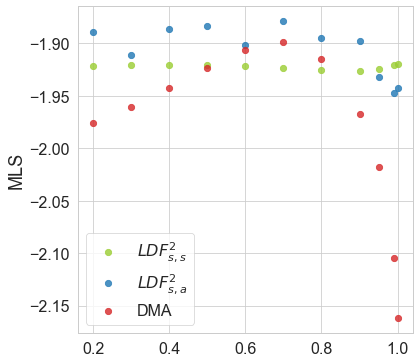

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.scatter(ldfs_df[0].to_list()[:-1], ldfs_df[1].to_list()[:-1], marker='o', color='yellowgreen', label="$LDF_{s, s}^2$", s=40, alpha=0.8)
ax.scatter(ldfa_df[0].to_list()[:-1], ldfa_df[1].to_list()[:-1], marker='o', color='tab:blue', label="$LDF_{s, a}^2$", s=40, alpha=0.8)
ax.scatter(res_dma_df[0].to_list()[:-1], res_dma_df[1].to_list()[:-1], marker='o', color='tab:red', label="DMA", s=40, alpha=0.8)
ax.set_ylabel(r"MLS")
ax.legend(loc="lower left");

### 2-level LDF(softmax, argmax) $\delta=0.7$ probability rectangles

In [65]:
res_best = ldf(forecast_table.to_numpy().astype(float).T, levels=2, discount_factors=[discount_factors, np.asarray([0.7])], activation_functions=["softmax", "argmax"], c=c)
weights = res_best["weights"][0,-75:]

In [66]:
bma_mom_weights = pd.DataFrame(weights, columns=forecast_table.columns, index=np.arange(8, 74+9)).stack().reset_index()
bma_mom_weights.columns = ["PERIOD_ENUM", "FCT_SOURCE", "WEIGHT"]

In [67]:
bma_mom_weights_hist = filled_history.merge(bma_mom_weights, on=["PERIOD_ENUM", "FCT_SOURCE"])

In [68]:
bma_mom_weights_hist.loc[:, target_buckets] = (bma_mom_weights_hist.WEIGHT.values * bma_mom_weights_hist[target_buckets].T).T.to_numpy()

In [69]:
realisations = filled_history[["TARGET_PERIOD", "CHANGE"]].set_index("TARGET_PERIOD", drop=True).copy().drop_duplicates()

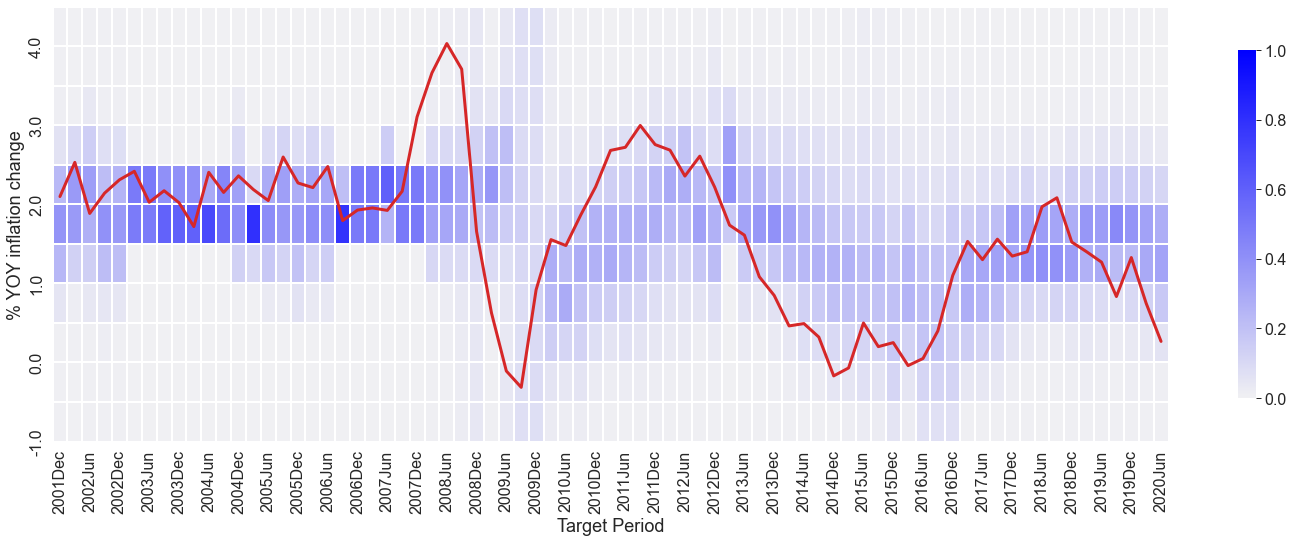

In [70]:
fig, ax = plt.subplots(figsize=(25,8))
filled_history["LIK"]  = filled_history["LIK"].astype("float")
filled_history["CHANGE"]  = filled_history["CHANGE"].astype("float")
cmap = sns.color_palette("light:b", as_cmap=True)
df_bma_mom_prob = bma_mom_weights_hist.groupby("TARGET_PERIOD").sum()[target_buckets]
df_bma_mom_prob = df_bma_mom_prob.reindex(realisations.index).loc[realisations[8:].index]
df_bma_mom_prob.columns = (np.array([-1] + buckets_from[1:]) + np.array(buckets_to[:-1]+[4.5])) * 0.5
sns.heatmap(df_bma_mom_prob.T.iloc[::-1]/100, ax=ax, cmap=cmap,
           linewidth=0.3, cbar_kws={"shrink": .8}, square=False, vmin=0, vmax=1)

ax.set_yticks(np.arange(0,12))
ax.plot(np.arange(0,75)+0.5, -(realisations.CHANGE.values[8:] - 4.5) * (12/6), c="tab:red", lw=3)
ax.set_yticklabels([Text(0, 0.5, ''),
 Text(0, 1, '4.0'),
 Text(0, 2.5, ''),
 Text(0, 3, '3.0'),
 Text(0, 4.5, ''),
 Text(0, 5, '2.0'),
 Text(0, 6.5, ''),
 Text(0, 7, '1.0'),
 Text(0, 8.5, ''),
 Text(0, 9, '0.0'),
 Text(0, 10.5, ''),
 Text(0, 11, '-1.0')])
ax.set_ylabel("% YOY inflation change")
ax.set_xlabel("Target Period")
plt.show()